In [6]:
## Montar google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Cargar el archivo desde Google Drive
import pandas as pd

# Especifica la ruta completa del archivo en tu Google Drive
file_path = '/content/drive/MyDrive/MachineLearning/TRAIN/GPT/grouped_trainytrial.xlsx'


# Cargar el archivo Excel en un DataFrame
df = pd.read_excel(file_path)

In [11]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Codificar la columna 'sentiment' en valores numéricos
label_encoder_sentiment = LabelEncoder()
df['sentiment_numeric'] = label_encoder_sentiment.fit_transform(df['sentiment'])


# Seleccionar características específicas
columnas_seleccionadas = [
    'POS','NEU','NEG', 'toxicity',
    'tristeza' ,'miedo','enojo','disgusto', 'sorpresa',
    'alegria',
    'num_palabras_largas',
    'falta de motivacion',
    'aislamiento social',
    'pensamientos suicidas',
    'baja autoestima',
    'insomnio',
    'pensamientos acelerados',
    'ataques de panico',
    'negaciones'
]

# Normalizar solo las columnas numéricas específicas
scaler = MinMaxScaler()
cols_to_normalize = [
    'num_palabras_largas','negaciones','num_palabras_mayusculas',
   'num_palabras_primera_mayuscula', 'num_signos_puntuacion',

]

# Verificar que las columnas a normalizar existan en el DataFrame antes de normalizar
cols_to_normalize = [col for col in cols_to_normalize if col in df.columns]
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

# Seleccionar las características
X = df[columnas_seleccionadas].copy()

# Codificar las etiquetas de la columna 'label'
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])  # 0, 1 y 2 deben estar en esta columna

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)




Entrena el modelo


In [12]:
!pip install -U imbalanced-learn  # solo si estás en Google Colab

from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Aplicar SMOTE solo sobre el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Entrenar Naive Bayes con datos balanceados
nb_model = GaussianNB()
nb_model.fit(X_train_resampled, y_train_resampled)

# Predecir sobre el test sin alterar
y_pred = nb_model.predict(X_test)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Mostrar resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nReporte por clase:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_.astype(str)))



Accuracy: 0.7603
Precision: 0.7722
Recall: 0.7603
F1 Score: 0.7626

Reporte por clase:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        76
           1       0.76      0.73      0.74        51
           2       0.59      0.84      0.70        19

    accuracy                           0.76       146
   macro avg       0.73      0.78      0.74       146
weighted avg       0.77      0.76      0.76       146



**Validacion cruzada**

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# Crear el modelo
nb_model = GaussianNB()

# Definir la validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir las métricas personalizadas
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Realizar validación cruzada para cada métrica
scores = {}
for metric_name, scorer in scoring.items():
    metric_scores = cross_val_score(nb_model, X, y, cv=cv, scoring=scorer)
    scores[metric_name] = metric_scores
    print(f"{metric_name.capitalize()} (Validación Cruzada): {metric_scores.mean():.4f} ± {metric_scores.std():.4f}")

# Mostrar resultados consolidados
print("\n=== Resultados Consolidados ===")
for metric_name, metric_scores in scores.items():
    print(f"{metric_name.capitalize()}: Promedio = {metric_scores.mean():.4f}, Desviación Estándar = {metric_scores.std():.4f}")


Accuracy (Validación Cruzada): 0.6371 ± 0.1030
Precision (Validación Cruzada): 0.6639 ± 0.0605
Recall (Validación Cruzada): 0.6371 ± 0.1030
F1 (Validación Cruzada): 0.6197 ± 0.1166

=== Resultados Consolidados ===
Accuracy: Promedio = 0.6371, Desviación Estándar = 0.1030
Precision: Promedio = 0.6639, Desviación Estándar = 0.0605
Recall: Promedio = 0.6371, Desviación Estándar = 0.1030
F1: Promedio = 0.6197, Desviación Estándar = 0.1166


In [2]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import MultinomialNB

# Discretizar los datos
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_train_discretized = discretizer.fit_transform(X_train)

# Entrenar el modelo MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_discretized, y_train)

# Calcular importancia con log-probabilidades
log_prob = nb_model.feature_log_prob_
feature_importance = log_prob.max(axis=0) - log_prob.min(axis=0)

# Crear DataFrame para graficar
df_importancia = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': feature_importance
}).sort_values(by='Importancia', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(df_importancia['Característica'], df_importancia['Importancia'], color='skyblue')
plt.xlabel('Log Probabilidad')
plt.ylabel('Característica')
plt.title('Importancia de Características - MultinomialNB')
plt.gca().invert_yaxis()
plt.show()

NameError: name 'X_train' is not defined

Importancia de caracteeristicas

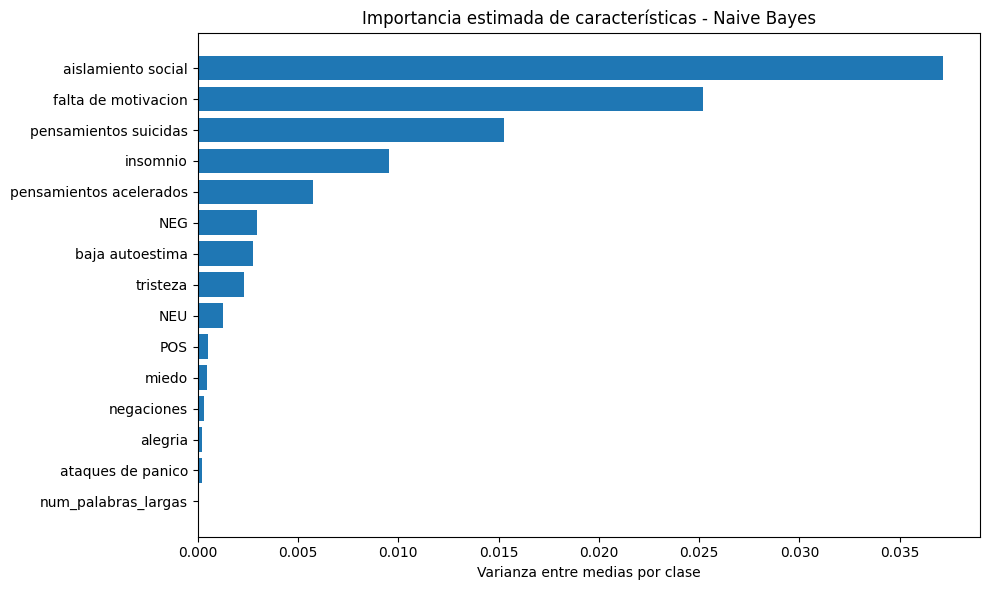

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Asegurate de que el modelo ya esté entrenado:
# nb_model = GaussianNB()
# nb_model.fit(X_train, y_train)

# Calcular varianza entre medias por clase para cada feature
variabilidad = np.var(nb_model.theta_, axis=0)

# Crear DataFrame con resultados
importancia_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importancia (var medias)': variabilidad
}).sort_values(by='Importancia (var medias)', ascending=False)

# Visualizar top 15 características
top = importancia_df.head(15)

plt.figure(figsize=(10, 6))
plt.barh(top['Feature'], top['Importancia (var medias)'])
plt.gca().invert_yaxis()
plt.xlabel("Varianza entre medias por clase")
plt.title("Importancia estimada de características - Naive Bayes")
plt.tight_layout()
plt.show()
